# Iterative하게 모든 SAMPLE에 대해서 Training

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import random
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from pytorch_forecasting.metrics import SMAPE
from captum.attr import IntegratedGradients,NoiseTunnel

/home/sjlee/sj_virtual/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. 모델 구성하기

In [2]:
data = pd.read_csv('./TrafficData/2-Copy1.csv')
data = data['volumn']
sequence_length = 1440
pred_len = 1

In [3]:
from torch import FloatTensor as FloatTensor

In [4]:
def seq_data(x,sequence_length,pred_len):
    seq_list = []
    target_list = []
    device = torch.device("cuda:0")
    for i in range(len(x)-sequence_length-pred_len):
        seq_list.append(x.iloc[i:i+sequence_length].values)
        target_list.append(x.iloc[i+sequence_length:i+sequence_length+pred_len].values)

    return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)

In [5]:
split = 10080

In [6]:
seed = 42

In [7]:
device = torch.device("cuda:0")

In [8]:
X_test = torch.FloatTensor(data.iloc[-split-sequence_length:-split].values).to(device)
# X_train의 마지막 인덱스에서 sequece_length만큼 뒤에 부분을 잘라오기
X_test = X_test.view(1,1,sequence_length)

In [9]:
target = data.iloc[-split]
target = FloatTensor([target]).view(-1,1)
target

tensor([[992707.]])

In [10]:
class Model(nn.Module):
    def __init__(self,train_index):
        super().__init__()
        self.seq_len = len(train_index)
        self.pred_len = 1
        self.train_index = train_index
        self.first_layer = nn.Linear(self.seq_len,self.pred_len)
        self.first_layer.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
    def forward(self,x):
        return self.first_layer(x[:,:,self.train_index]) 

# 2. Train-Validation set으로 쪼개기

In [11]:
data

0        501476
1        502010
2        499172
3        497707
4        499592
          ...  
38875    997648
38876    997761
38877    997509
38878    996789
38879    997017
Name: volumn, Length: 38880, dtype: int64

* 10080개는 test set 
* 28800개 중 0.2의 비율인 1440*4 = 5760개는 validation set
* 28800개 중 0.8의 비율인 28800-5760 = 23040개는 train set

In [12]:
train = data.iloc[:-split-5760]
val = data.iloc[-split-5760:-split]
x_train,y_train = seq_data(train,sequence_length=1440,pred_len=1)
x_val,y_val = seq_data(val,sequence_length=1440,pred_len=1)
train_dataset = TensorDataset(x_train,y_train)
val_dataset = TensorDataset(x_val,y_val)
training = DataLoader(train_dataset,batch_size=64)
validation = DataLoader(val_dataset,batch_size=64)

/tmp/ipykernel_181638/4291513198.py:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)


In [13]:
next(iter(validation))[0].size()

torch.Size([64, 1, 1440])

### 위와 같은 방식으로 validation-set에 대해서 기여도를 구하면 될 것이다.
-> 모든 batch의 각 sample에 대해서 Ig를 통한 attribution을 구해서 모든 batch에 걸쳐서 더한후 그것을 평균시킨다.<br>
-> 결과적으로 모든 validation set에 대한 attribution을 평균한다.

In [14]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed) # 난수 선언(원래는 cnt선언 위에 있었다)
train_index = np.arange(1440)
model = Model(train_index).to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
criterion = SMAPE()
num_epochs = 100
n= len(training)

### 기본 모델 training

In [15]:
import copy

In [16]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
minimal_loss=200
for epoch in range(num_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for inputs, labels in training:
        # forward pass
        inputs = inputs
        outputs = model(inputs)
        outputs = outputs.view(-1,1)
        labels = labels.view(-1,1)         
        # defining loss
        loss = criterion(outputs, labels)
        # zero the parameter gradients
        optimizer.zero_grad()
        # computing gradients
        loss.backward()
        # accumulating running loss
        running_loss += loss.item()
        # updated weights based on computed gradients
        optimizer.step()
    if epoch % 20 == 0:    
        print('Epoch [%d]/[%d] running accumulative loss across all batches: %.3f' %(epoch + 1, num_epochs, (running_loss/n)*100))
    if (running_loss/n)*100<minimal_loss:
        best_model = copy.deepcopy(model)
        minimal_loss = (running_loss/n)*100
        print("changed")

model = best_model

Epoch [1]/[100] running accumulative loss across all batches: 9.184
changed
changed
changed
Epoch [21]/[100] running accumulative loss across all batches: 8.758
changed
changed
Epoch [41]/[100] running accumulative loss across all batches: 13.515
Epoch [61]/[100] running accumulative loss across all batches: 8.109
Epoch [81]/[100] running accumulative loss across all batches: 11.403


### validation set에 대해서 attribution 구하기

In [17]:
n = len(validation)
n

68

In [18]:
cnt = 0
ig = IntegratedGradients(model)
nt_ig = NoiseTunnel(ig)
nt_ig_attr_score = torch.zeros((1,1440))
for val in validation:
    temp_n = val[0].size(0)
    temp = nt_ig.attribute(val[0]).sum(axis = 0) # axis=0으로 batch axis를 기준으로 다 더했음
    nt_ig_attr_score = nt_ig_attr_score.to(device)+temp
    cnt = cnt + temp_n
nt_ig_attr_score = nt_ig_attr_score/cnt
nt_ig_attr_score = nt_ig_attr_score.cpu().numpy().reshape(-1)

In [19]:
len(nt_ig_attr_score)

1440

<AxesSubplot: >

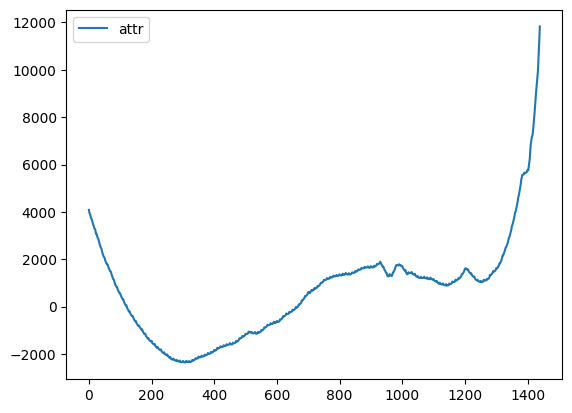

In [20]:
attr_df = pd.DataFrame({'attr':nt_ig_attr_score})
attr_df.plot()

### outlier가 감쇄 됐음을 확인할 수 있다.

#### scaling

In [21]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
attr_df = scaler.fit_transform(attr_df.values)
attr_df = pd.DataFrame({"attr":attr_df.reshape(-1)})
attr_df

,attr
0,1.615363
1,1.584473
2,1.553722
3,1.539001
4,1.520489
...,...
1435,4.629188
1436,4.775573
1437,4.925732
1438,5.073442


#### train_index구하기

In [22]:
index_list = []

for hyper_parameter in np.arange(0.01,1.01,0.01):
    append_idx = list(attr_df[(attr_df['attr']>hyper_parameter) | (attr_df['attr']<-hyper_parameter)].index)
    index_list.append(append_idx)
len(index_list) # train_index의 리스트

100

In [23]:
len_list=[]
for i in range(100):
    len_list.append(len(index_list[i]))


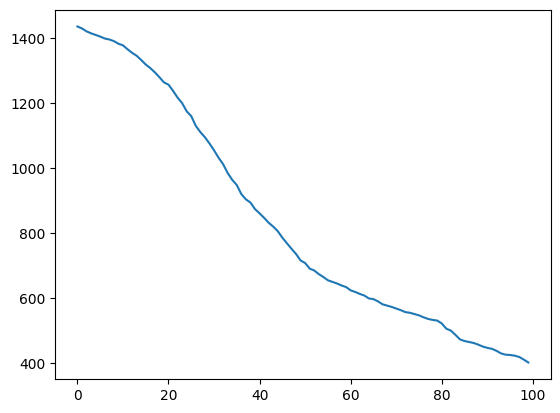

In [24]:
plt.plot(np.arange(100),len_list) # 포함되는 time_index의 갯수

In [25]:
for val_x,val_y in validation:
    print(val_x,val_y)

tensor([[[940732., 941340., 940432.,  ..., 955413., 955437., 955440.]],

        [[941340., 940432., 937222.,  ..., 955437., 955440., 957355.]],

        [[940432., 937222., 938957.,  ..., 955440., 957355., 958682.]],

        ...,

        [[929015., 928707., 926359.,  ..., 947163., 945433., 947380.]],

        [[928707., 926359., 927332.,  ..., 945433., 947380., 947435.]],

        [[926359., 927332., 925809.,  ..., 947380., 947435., 947141.]]],
       device='cuda:0') tensor([[[957355.]],

        [[958682.]],

        [[956990.]],

        [[955565.]],

        [[956750.]],

        [[956314.]],

        [[955833.]],

        [[954898.]],

        [[956095.]],

        [[953856.]],

        [[956062.]],

        [[956586.]],

        [[954623.]],

        [[953165.]],

        [[954106.]],

        [[952252.]],

        [[953668.]],

        [[951199.]],

        [[952878.]],

        [[951524.]],

        [[953557.]],

        [[954513.]],

        [[953190.]],

        [[951784.]

tensor([[[939693., 939989., 939845.,  ..., 970038., 969848., 970297.]],

        [[939989., 939845., 939941.,  ..., 969848., 970297., 971140.]],

        [[939845., 939941., 940837.,  ..., 970297., 971140., 970208.]],

        ...,

        [[953323., 950775., 953057.,  ..., 921093., 920331., 922528.]],

        [[950775., 953057., 951694.,  ..., 920331., 922528., 921042.]],

        [[953057., 951694., 955341.,  ..., 922528., 921042., 922990.]]],
       device='cuda:0') tensor([[[971140.]],

        [[970208.]],

        [[971606.]],

        [[970641.]],

        [[972439.]],

        [[973596.]],

        [[972455.]],

        [[971155.]],

        [[972941.]],

        [[971086.]],

        [[972468.]],

        [[972371.]],

        [[972916.]],

        [[971872.]],

        [[973914.]],

        [[975922.]],

        [[974159.]],

        [[974702.]],

        [[974429.]],

        [[975146.]],

        [[975221.]],

        [[974977.]],

        [[975143.]],

        [[975996.]

       device='cuda:0') tensor([[[960538.]],

        [[961318.]],

        [[961775.]],

        [[963940.]],

        [[961031.]],

        [[962970.]],

        [[962576.]],

        [[963758.]],

        [[960918.]],

        [[962826.]],

        [[960739.]],

        [[961512.]],

        [[961521.]],

        [[965820.]],

        [[960377.]],

        [[961087.]],

        [[958291.]],

        [[961410.]],

        [[958405.]],

        [[961707.]],

        [[959190.]],

        [[960673.]],

        [[958609.]],

        [[963276.]],

        [[960159.]],

        [[960705.]],

        [[958443.]],

        [[960735.]],

        [[958045.]],

        [[960111.]],

        [[959021.]],

        [[960835.]],

        [[958530.]],

        [[962729.]],

        [[957861.]],

        [[959365.]],

        [[956745.]],

        [[959376.]],

        [[956367.]],

        [[958996.]],

        [[955855.]],

        [[958472.]],

        [[955849.]],

        [[960639.]],

        

       device='cuda:0') tensor([[[924427.]],

        [[925680.]],

        [[924215.]],

        [[923111.]],

        [[923459.]],

        [[922859.]],

        [[922735.]],

        [[922261.]],

        [[923157.]],

        [[922870.]],

        [[923460.]],

        [[924317.]],

        [[923759.]],

        [[922789.]],

        [[922851.]],

        [[921738.]],

        [[922277.]],

        [[921690.]],

        [[921685.]],

        [[921127.]],

        [[922546.]],

        [[924240.]],

        [[923273.]],

        [[922130.]],

        [[922523.]],

        [[922974.]],

        [[922499.]],

        [[920872.]],

        [[920847.]],

        [[920695.]],

        [[920973.]],

        [[922235.]],

        [[921570.]],

        [[920249.]],

        [[920594.]],

        [[920103.]],

        [[920361.]],

        [[919207.]],

        [[920372.]],

        [[920007.]],

        [[920784.]],

        [[922112.]],

        [[921487.]],

        [[920549.]],

        

tensor([[[942224., 942741., 942337.,  ..., 979310., 977198., 977282.]],

        [[942741., 942337., 943759.,  ..., 977198., 977282., 977536.]],

        [[942337., 943759., 942362.,  ..., 977282., 977536., 978300.]],

        ...,

        [[945924., 949217., 947403.,  ..., 981269., 980397., 981507.]],

        [[949217., 947403., 950769.,  ..., 980397., 981507., 979970.]],

        [[947403., 950769., 950912.,  ..., 981507., 979970., 981312.]]],
       device='cuda:0') tensor([[[977536.]],

        [[978300.]],

        [[978822.]],

        [[979902.]],

        [[978605.]],

        [[980737.]],

        [[977215.]],

        [[979857.]],

        [[977015.]],

        [[977850.]],

        [[975852.]],

        [[978464.]],

        [[976314.]],

        [[977621.]],

        [[977086.]],

        [[981447.]],

        [[978590.]],

        [[978285.]],

        [[977664.]],

        [[977571.]],

        [[977902.]],

        [[977383.]],

        [[976536.]],

        [[977512.]

       device='cuda:0') tensor([[[990470.]],

        [[988444.]],

        [[989763.]],

        [[988531.]],

        [[989848.]],

        [[990515.]],

        [[994823.]],

        [[989568.]],

        [[992402.]],

        [[991461.]],

        [[990903.]],

        [[987960.]],

        [[989471.]],

        [[987589.]],

        [[988714.]],

        [[987421.]],

        [[989281.]],

        [[986441.]],

        [[989096.]],

        [[989158.]],

        [[988297.]],

        [[985523.]],

        [[988494.]],

        [[985938.]],

        [[988025.]],

        [[986420.]],

        [[988538.]],

        [[986640.]],

        [[989071.]],

        [[987884.]],

        [[987791.]],

        [[986270.]],

        [[987086.]],

        [[985053.]],

        [[987057.]],

        [[985887.]],

        [[987515.]],

        [[985888.]],

        [[989274.]],

        [[988447.]],

        [[988002.]],

        [[985745.]],

        [[987400.]],

        [[985417.]],

        

       device='cuda:0') tensor([[[954792.]],

        [[953183.]],

        [[959397.]],

        [[957845.]],

        [[956414.]],

        [[953838.]],

        [[955553.]],

        [[954507.]],

        [[956113.]],

        [[955136.]],

        [[956177.]],

        [[955381.]],

        [[957981.]],

        [[959083.]],

        [[958938.]],

        [[956872.]],

        [[957451.]],

        [[957556.]],

        [[957393.]],

        [[955974.]],

        [[957332.]],

        [[955659.]],

        [[959387.]],

        [[960032.]],

        [[962409.]],

        [[957507.]],

        [[957827.]],

        [[957169.]],

        [[958685.]],

        [[957314.]],

        [[958875.]],

        [[957645.]],

        [[962719.]],

        [[963329.]],

        [[960847.]],

        [[958536.]],

        [[959248.]],

        [[960291.]],

        [[960917.]],

        [[959324.]],

        [[958934.]],

        [[959327.]],

        [[960967.]],

        [[963032.]],

        

tensor([[[ 985965.,  984652.,  985532.,  ..., 1009863., 1005955., 1008900.]],

        [[ 984652.,  985532.,  986797.,  ..., 1005955., 1008900., 1006076.]],

        [[ 985532.,  986797.,  985940.,  ..., 1008900., 1006076., 1009847.]],

        ...,

        [[ 986031.,  983426.,  988523.,  ..., 1008630., 1007148., 1008002.]],

        [[ 983426.,  988523.,  984089.,  ..., 1007148., 1008002., 1008561.]],

        [[ 988523.,  984089.,  985396.,  ..., 1008002., 1008561., 1010667.]]],
       device='cuda:0') tensor([[[1006076.]],

        [[1009847.]],

        [[1006534.]],

        [[1011605.]],

        [[1005847.]],

        [[1009700.]],

        [[1008184.]],

        [[1008557.]],

        [[1005617.]],

        [[1008424.]],

        [[1006849.]],

        [[1008373.]],

        [[1007218.]],

        [[1011817.]],

        [[1008336.]],

        [[1010049.]],

        [[1008274.]],

        [[1009658.]],

        [[1007408.]],

        [[1009317.]],

        [[1007016.]],

     

In [26]:
val_x

tensor([[[975405., 975448., 976719.,  ..., 999613., 998654., 999026.]],

        [[975448., 976719., 978057.,  ..., 998654., 999026., 996774.]],

        [[976719., 978057., 976281.,  ..., 999026., 996774., 998172.]],

        ...,

        [[971361., 970502., 970869.,  ..., 993983., 993015., 992942.]],

        [[970502., 970869., 971871.,  ..., 993015., 992942., 993033.]],

        [[970869., 971871., 972278.,  ..., 992942., 993033., 992544.]]],
       device='cuda:0')

In [27]:
### 원래 난수가 선언된 위치
m = len(validation)
n = len(training)
cnt = 0
out_list = []
num_epochs = 100
criterion = SMAPE()
for idx in index_list: #0.01~1.00 100개의 index에 대해서 수행
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed) # 난수 선언(원래는 cnt선언 위에 있었다)
    train_idx = idx
    minimal_loss=200
    model = Model(train_idx).to(device) # 모델 초기화
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) # optimizer 초기화
    result = 0
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for inputs, labels in training:
            # forward pass
            inputs = inputs
            
            outputs = model(inputs)
            
            outputs = outputs.view(-1,1)
            labels = labels.view(-1,1)         
            
            # defining loss
            loss = criterion(outputs, labels)
            # zero the parameter gradients
            optimizer.zero_grad()
            # computing gradients
            loss.backward()
            # accumulating running loss
            running_loss += loss.item()
            # updated weights based on computed gradients
            optimizer.step()
        if epoch == 99:    
            print(f'{cnt}번째 모델 Training 완료 마지막 Epoch loss:{(running_loss/n)*100}')
        
        if (running_loss/n)*100<minimal_loss:
            best_model = copy.deepcopy(model)
            minimal_loss = (running_loss/n)*100
            print("changed")

    model = best_model
    cnt+=1
    # 모델 Fully-Training 완료
    
    pred = torch.FloatTensor().to(device)
    val_target = torch.FloatTensor().to(device)
    for val_x,val_y in validation:
        tmp_pred = model(val_x)
        pred = torch.concat([pred,tmp_pred], dim=0)
        val_target = torch.concat([val_target,val_y],dim = 0)
    pred = pred.view(-1,1)
    val_target = val_target.view(-1,1)
    result = criterion(pred,val_target).item()*100
    out_list.append(result)
    


changed
changed
changed
changed
changed
changed
0번째 모델 Training 완료 마지막 Epoch loss:10.521524894972933
changed
changed
changed
changed
changed
1번째 모델 Training 완료 마지막 Epoch loss:14.833437578928981
changed
changed
changed
changed
changed
changed
2번째 모델 Training 완료 마지막 Epoch loss:10.923959230783687
changed
changed
changed
changed
changed
3번째 모델 Training 완료 마지막 Epoch loss:10.571724794923531
changed
changed
changed
changed
4번째 모델 Training 완료 마지막 Epoch loss:7.511455020571084
changed
changed
changed
5번째 모델 Training 완료 마지막 Epoch loss:8.367393906923981
changed
changed
changed
changed
6번째 모델 Training 완료 마지막 Epoch loss:13.822313307470383
changed
changed
changed
changed
7번째 모델 Training 완료 마지막 Epoch loss:8.32983970238425
changed
changed
changed
changed
changed
changed
8번째 모델 Training 완료 마지막 Epoch loss:9.113770548788798
changed
changed
changed
changed
changed
changed
9번째 모델 Training 완료 마지막 Epoch loss:10.471857126771896
changed
changed
changed
changed
10번째 모델 Training 완료 마지막 Epoch loss:9.92127377105898

changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
64번째 모델 Training 완료 마지막 Epoch loss:2.097215802414266
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
65번째 모델 Training 완료 마지막 Epoch loss:2.0512171280460114
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
66번째 모델 Training 완료 마지막 Epoch loss:1.9233259420976947
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
67번째 모델 Training 완료 마지막 Epoch loss:2.5570015212556774
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
68번째 모델 Training 완료 마지막 Epoch los

In [28]:
val_y # 다음 예측 타겟값

tensor([[[ 996774.]],

        [[ 998172.]],

        [[ 997946.]],

        [[1001005.]],

        [[ 996760.]],

        [[ 997438.]],

        [[ 996847.]],

        [[ 998169.]],

        [[ 996612.]],

        [[ 996987.]],

        [[ 996618.]],

        [[ 998817.]],

        [[ 996985.]],

        [[1000925.]],

        [[ 996990.]],

        [[ 998813.]],

        [[ 995387.]],

        [[ 996522.]],

        [[ 995198.]],

        [[ 995126.]],

        [[ 994120.]],

        [[ 993929.]],

        [[ 994070.]],

        [[ 997274.]],

        [[ 995317.]],

        [[ 993983.]],

        [[ 993015.]],

        [[ 992942.]],

        [[ 993033.]],

        [[ 992544.]],

        [[ 992342.]]], device='cuda:0')

In [29]:
val_x # 예측 하는 값

tensor([[[975405., 975448., 976719.,  ..., 999613., 998654., 999026.]],

        [[975448., 976719., 978057.,  ..., 998654., 999026., 996774.]],

        [[976719., 978057., 976281.,  ..., 999026., 996774., 998172.]],

        ...,

        [[971361., 970502., 970869.,  ..., 993983., 993015., 992942.]],

        [[970502., 970869., 971871.,  ..., 993015., 992942., 993033.]],

        [[970869., 971871., 972278.,  ..., 992942., 993033., 992544.]]],
       device='cuda:0')

In [30]:
result/68

0.015237957567853086

In [31]:
val_x.size()

torch.Size([31, 1, 1440])

In [32]:
model(X_test)

tensor([[[994455.9375]]], device='cuda:0', grad_fn=<ViewBackward0>)

In [33]:
out_df = pd.DataFrame({"out":out_list})

# Out Result

<AxesSubplot: >

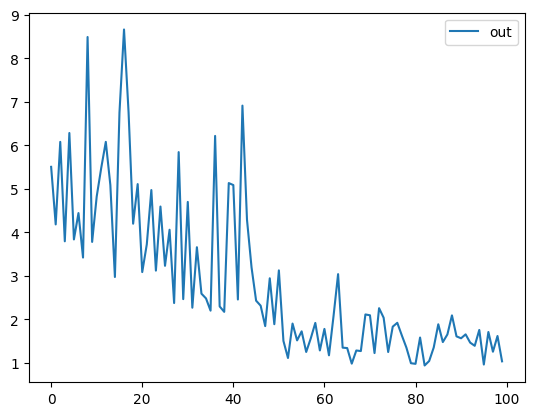

In [34]:
out_df.plot()

In [35]:
out_df.min()

out    0.941145
dtype: float64

In [36]:
out_df[out_df['out']==out_df['out'].min()]

,out
82,0.941145


# Result
- 변동성이 줄어들고, 최소를 한번 찍고나면, 그 최소를 뚫기가 어려운 것으로 보인다.

In [37]:
attr_df.describe()

,attr
count,1.440000e+03
mean,3.947460e-17
std,1.000347e+00
min,-1.413497e+00
25%,-8.151544e-01
50%,1.845747e-01
75%,3.954876e-01
max,5.256842e+00
